In [1]:
# Version 1.0

# INFO 523:       Professor Hong Cui
# Authors:        Alexander Lin & Jennifer Kadowaki
# Last Modified:  2018 Dec 05

---
# <font color='red'>Using Population Demographics to Predict the 2016 United States Election</font>

### By:   Alexander Lin  (<font color='blue'>alexanderliwaylin@gmail.com</font>)   &   Jennifer Kadowaki  (<font color='blue'>jkadowaki@email.arizona.edu</font>)

---
# $\S$1. <font color='blue'>Introduction</blue>

In today's highly devisive political atmosphere in the United States, we want to understand the political divide and the voting patterns of Americans. To understand this divide, we analyze the 2016 United States presidential election results against the backdrop of the 2014 county-level population demographics.

## 1.1. <font color='green'>Goals</font>
1. Discover association rules between the American population demographic & the overall election results to undercover underlying trends in our data.
2. Determine important features to use as election result predictors.
3. Generate & evaluate predictions of the 2016 election results solely using the 2014 demographic data from multiple machine learning techniques.

## 1.2. <font color='green'>Acknowledgements</font>
The [2014 population demographics data](https://www.kaggle.com/benhamner/2016-us-election/home) was made available by user "benhamner" on Kaggle. Our dataset joins the [2016 US Presidential election data](https://github.com/tonmcg/US_County_Level_Election_Results_08-16) provided by user "tonmcg" on GitHub.

---
# $\S$2. <font color='blue'>Import Packages</font>

In [13]:
######### FILTER PACKAGE WARNINGS ########

import warnings  # Turn Off Frequent Warnings from Packages
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

###### PYTHON VERSION COMPATIBILITY ######

from __future__ import print_function  # print() Function in Python 2

try:
    input = raw_input  # 'input' Function in Python 2 & 3
except NameError:
    pass


########## MACHINE LEARNING APIs ##########

# SCIKIT-LEARN
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, f_regression, RFECV, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss, mean_squared_error, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import Imputer, LabelEncoder

# KERAS
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard


############ DATA & MANIPULATION ##########

import numpy as np
from random import setstate, shuffle

# Turn Off Deprecation & Future Warnings from Pandas
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings("ignore",category=FutureWarning)
    import pandas as pd

# Display All Rows & Columns in DataFrame
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

# Pandas for Geographical Data
#import geopandas
from shapely.geometry import Point
import plotly.plotly as py
import plotly.figure_factory as ff


################ PLOTTING ################

# SEABORN
import seaborn as sns

# MATPLOTLIB
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
%matplotlib inline

# equivalent to rcParams['animation.html'] = 'html5'
matplotlib.rc('animation', html='html5')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


############# FILE MANAGEMENT #############

import errno
import io
import os
import urllib.request

---
# $\S$3. <font color='blue'>Loading the Data</font>

#### Define file name & location.

In [4]:
directory    = 'data'
dict_file    = 'county_facts_dictionary.csv'
county_file  = 'county_facts.csv'
results_file = '2016_US_County_Level_Presidential_Results.csv'
rdf_file     = 'reduced_election_data.csv'

#### Load data into a pandas dataframe.

In [14]:
dict_data    = pd.read_csv(os.path.join(directory, dict_file),    sep=',')
county_data  = pd.read_csv(os.path.join(directory, county_file),  sep=',')
results_data = pd.read_csv(os.path.join(directory, results_file), sep=',')
rdf          = pd.read_csv(os.path.join(directory, rdf_file),     sep=',')

#### Print available features

In [5]:
dict_data

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"
5,AGE295214,"Persons under 18 years, percent, 2014"
6,AGE775214,"Persons 65 years and over, percent, 2014"
7,SEX255214,"Female persons, percent, 2014"
8,RHI125214,"White alone, percent, 2014"
9,RHI225214,"Black or African American alone, percent, 2014"


#### Preview the Population Demographics Data

In [6]:
county_data.head(10)

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,NaN,318857056,308758105,3.3,308745538,6.2,23.1,14.5,50.8,77.4,13.2,1.2,5.4,0.2,2.5,17.4,62.1,84.9,12.9,20.7,86.0,28.8,21263779,25.5,133957180,64.9,26.0,176700,115610216,2.63,28155,53046,15.4,7488353,118266253,2.0,23005620,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,NaN,4849377,4780127,1.4,4779736,6.1,22.8,15.3,51.5,69.7,26.7,0.7,1.3,0.1,1.5,4.1,66.2,85.0,3.5,5.2,83.1,22.6,388865,24.2,2207912,69.7,15.9,122500,1838683,2.55,23680,43253,18.6,97578,1603100,1.1,311578,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,51.4,77.9,18.7,0.5,1.1,0.1,1.8,2.7,75.6,85.0,1.6,3.5,85.6,20.9,5922,26.2,22751,76.8,8.3,136200,20071,2.71,24571,53682,12.1,817,10120,2.1,2947,4067,15.2,0.0,1.3,0.0,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,51.2,87.1,9.6,0.7,0.9,0.1,1.6,4.6,83.0,82.1,3.6,5.5,89.1,27.7,19346,25.9,107374,72.6,24.4,168600,73283,2.52,26766,50221,13.9,4871,54988,3.7,16508,19035,2.7,0.4,1.0,0.0,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,46.6,50.2,47.6,0.6,0.5,0.2,0.9,4.5,46.6,84.8,2.9,5.0,73.7,13.4,2120,24.6,11799,67.7,10.6,89200,9200,2.66,16829,32911,26.7,464,6611,-5.6,1546,1667,0.0,0.0,0.0,0.0,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
5,1007,Bibb County,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,45.9,76.3,22.1,0.4,0.2,0.1,0.9,2.1,74.5,86.6,1.2,2.1,77.5,12.1,1327,27.6,8978,79.0,7.3,90500,7091,3.03,17427,36447,18.1,275,3145,7.5,1126,1385,14.9,0.0,0.0,0.0,0.0,0.0,0,0,124707,5804,10757,19,622.58,36.8
6,1009,Blount County,AL,57719,57322,0.7,57322,6.1,23.6,17.0,50.5,96.0,1.8,0.6,0.3,0.1,1.2,8.7,87.8,88.7,4.3,7.3,77.0,12.1,4540,33.9,23826,81.0,4.5,117100,21108,2.70,20730,44145,15.8,660,6798,3.4,3563,4458,0.0,0.0,0.0,0.0,0.0,23.2,341544,0,319700,5622,20941,3,644.78,88.9
7,1011,Bullock County,AL,10764,10915,-1.4,10914,6.3,21.4,14.9,45.3,26.9,70.1,0.8,0.3,0.7,1.1,7.5,22.1,84.7,5.4,5.2,67.8,12.5,636,26.9,4461,74.3,8.7,70600,3741,2.73,18628,32033,21.6,112,0,0.0,470,417,0.0,0.0,0.0,0.0,0.0,38.8,0,0,43810,3995,3670,1,622.81,17.5
8,1013,Butler County,AL,20296,20946,-3.1,20947,6.1,23.6,18.0,53.6,53.9,44.0,0.4,0.9,0.0,0.8,1.2,53.1,94.6,0.8,1.7,76.3,14.0,1497,24.0,9916,70.3,13.3,74700,8235,2.47,17403,29918,28.4,393,5711,2.7,1095,1769,0.0,0.0,3.3,0.0,0.0,0.0,399132,56712,229277,11326,28427,2,776.83,27.0
9,1015,Calhoun County,AL,115916,118586,-2.3,118572,5.7,22.2,16.0,51.8,75.8,21.1,0.5,0.9,0.1,1.7,3.5,72.9,83.6,2.4,4.5,78.6,16.1,11385,22.5,53289,68.7,13.8,100600,45196,2.54,20828,39962,21.9,2311,34871,0.6,6352,8713,7.2,0.0,1.6,0.0,0.5,24.7,2679991,0,1542981,13678,186533,114,605.87,195.7


#### Preview the Election Results Data

In [7]:
results_data.head(10)

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060
5,5,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2068
6,6,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2070
7,7,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2090
8,8,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2100
9,9,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2105


#### United States Map of Voting Patterns

In [15]:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]

endpts = list(np.linspace(1, 12, len(colorscale) - 1))

fips = results_data["combined_fips"].values.tolist()
values = (results_data["per_dem"]-results_data["per_gop"]).values.tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Percentage Point Difference',
    legend_title='% Point Difference')

py.iplot(fig, filename='percentage_point_difference.pdf')

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands in the terminal to ensure that the correct versions of the modules are installed:
`pip install geopandas==0.3.0`
`pip install pyshp==1.2.10`
`pip install shapely==1.6.3`


---
# $\S$4. <font color='blue'>Cleaning the Data</font>
### <font color='red'>**DISCLAIMER**</font>: Please refer to Notebook #2 to see the data cleaning process.
---

### Preview the Reduced Election Results Data

In [8]:
rdf.head(10)

,County_Name,State,State_Index,NUM_POP_2014,PER_POP_Change,PER_Female,PER_White_Only,PER_Black,PER_Native_American,PER_Asian,PER_Pacific_Islander,Per_Multiracial,PER_Hispanic,PER_Color,PER_Same_Residence,PER_Foreign_Born,PER_DIFF_Age_Groups,PER_Veterans,PER_EDU_High_School,PER_EDU_College,NUM_Mean_Work_Travel_Time,PER_Homeownership,PER_Apartments,NUM_House_Value,NUM_Person_In_Households,NUM_INC_Per_Capita,NUM_INC_Median_Household,PER_Below_Poverty,PER_Not_Farm_Employment_Change,NUM_Firms_Per_Capita,PER_Firms_Color,PER_Firms_Women,PER_Merchant_Sales_Per_Capita,PER_Retail_Sales_Per_Capita,PER_Food_Sales_Per_Capita,NUM_Sales_Per_Capita,NUM_Building_Permits,NUM_Land_Area,NUM_Pop_Per_Area,PER_Voters,PER_Vote_Diff,Win_Strength,Party_Winner
0,Autauga County,AL,7,55395,1.5,51.4,75.6,18.7,0.5,1.1,0.1,1.8,2.7,24.9,85.0,3.5,11.4,10.690496,85.6,20.9,26.2,76.8,8.3,136200,2.71,24571,53682,12.1,2.1,0.073418,17.2,31.7,0.000000,10.798357,1.591425,12.389782,131,594.44,91.8,44.518458,-49.478934,-1,-1
1,Baldwin County,AL,7,200111,9.8,51.2,83.0,9.6,0.7,0.9,0.1,1.6,4.6,17.5,82.1,5.5,3.5,9.667634,89.1,27.7,25.9,72.6,24.4,168600,2.52,26766,50221,13.9,3.7,0.095122,5.4,27.3,0.000000,14.824218,2.183563,17.007781,1384,1589.78,114.6,47.018905,-57.786162,-2,-1
2,Barbour County,AL,7,26887,-2.1,46.6,46.6,47.6,0.6,0.5,0.2,0.9,4.5,54.3,84.8,5.0,4.7,7.884851,73.7,13.4,24.6,67.7,10.6,89200,2.66,16829,32911,26.7,-5.6,0.062000,0.0,27.0,0.000000,7.004761,0.000000,7.004761,8,884.88,31.0,38.643210,-5.611165,0,-1
3,Bibb County,AL,7,22506,-1.8,45.9,74.5,22.1,0.4,0.2,0.1,0.9,2.1,25.8,86.6,2.1,6.2,5.896205,77.5,12.1,27.6,79.0,7.3,90500,3.03,17427,36447,18.1,7.5,0.061539,14.9,0.0,0.000000,5.541056,0.477961,6.019017,19,622.58,36.8,38.869635,-55.544124,-2,-1
4,Blount County,AL,7,57719,0.7,50.5,87.8,1.8,0.6,0.3,0.1,1.2,8.7,12.7,88.7,7.3,6.6,7.865694,77.0,12.1,33.9,81.0,4.5,117100,2.70,20730,44145,15.8,3.4,0.077236,0.0,23.2,0.000000,5.538904,0.362809,5.901713,3,644.78,88.9,43.978586,-81.381973,-2,-1
5,Bullock County,AL,7,10764,-1.4,45.3,22.1,70.1,0.8,0.3,0.7,1.1,7.5,80.5,84.7,5.2,6.5,5.908584,67.8,12.5,26.9,74.3,8.7,70600,2.73,18628,32033,21.6,0.0,0.038740,0.0,38.8,0.000000,4.070048,0.340951,4.411000,1,622.81,17.5,43.673356,50.861519,2,1
6,Butler County,AL,7,20296,-3.1,53.6,53.1,44.0,0.4,0.9,0.0,0.8,1.2,47.3,94.6,1.7,5.6,7.375838,76.3,14.0,24.0,70.3,13.3,74700,2.47,17403,29918,28.4,2.7,0.087160,3.3,0.0,2.794245,11.296659,1.400621,15.491525,2,776.83,27.0,42.791683,-13.529073,0,-1
7,Calhoun County,AL,7,115916,-2.3,51.8,72.9,21.1,0.5,0.9,0.1,1.7,3.5,27.8,83.6,4.5,6.2,9.821767,78.6,16.1,22.5,68.7,13.8,100600,2.54,20828,39962,21.9,0.6,0.075166,9.3,24.7,0.000000,13.311199,1.609208,14.920408,114,605.87,195.7,40.870976,-41.383823,-1,-1
8,Chambers County,AL,7,34076,-0.3,52.3,56.8,39.5,0.3,0.8,0.1,1.1,2.0,43.8,85.8,1.3,3.1,7.897054,75.1,11.8,24.6,67.9,11.1,81200,2.46,19291,32402,24.1,-0.2,0.058135,0.0,29.3,0.000000,7.766463,0.681917,8.448380,8,596.53,57.4,40.433149,-14.806213,0,-1
9,Cherokee County,AL,7,26037,0.2,50.2,91.6,4.6,0.5,0.3,0.0,1.6,1.5,8.5,90.6,1.1,-0.5,8.349656,78.3,12.8,26.9,76.1,4.6,99400,2.20,22030,34907,21.2,5.5,0.083727,0.0,14.5,2.392480,7.156009,0.535699,10.084188,2,553.70,46.9,40.338749,-69.361135,-2,-1


### List of All the Numerical Features
These are features that will be fed into our random forest and feedforward neural network to predict results of the election.

In [9]:
features = rdf.columns[2:39]
features

Index(['State_Index', 'NUM_POP_2014', 'PER_POP_Change', 'PER_Female',
       'PER_White_Only', 'PER_Black', 'PER_Native_American', 'PER_Asian',
       'PER_Pacific_Islander', 'Per_Multiracial', 'PER_Hispanic', 'PER_Color',
       'PER_Same_Residence', 'PER_Foreign_Born', 'PER_DIFF_Age_Groups',
       'PER_Veterans', 'PER_EDU_High_School', 'PER_EDU_College',
       'NUM_Mean_Work_Travel_Time', 'PER_Homeownership', 'PER_Apartments',
       'NUM_House_Value', 'NUM_Person_In_Households', 'NUM_INC_Per_Capita',
       'NUM_INC_Median_Household', 'PER_Below_Poverty',
       'PER_Not_Farm_Employment_Change', 'NUM_Firms_Per_Capita',
       'PER_Firms_Color', 'PER_Firms_Women', 'PER_Merchant_Sales_Per_Capita',
       'PER_Retail_Sales_Per_Capita', 'PER_Food_Sales_Per_Capita',
       'NUM_Sales_Per_Capita', 'NUM_Building_Permits', 'NUM_Land_Area',
       'NUM_Pop_Per_Area'],
      dtype='object')

### List All of the Numerical Results
To predict these values, we much use a random forest regressor and a neural network with a linear/ReLU output activation layer. For the purposes of this project, we instead opt to do a classification task.

In [10]:
# Numerical Values to Predict
predict_var = rdf.columns[39:41]
predict_var

Index(['PER_Voters', 'PER_Vote_Diff'], dtype='object')

### List of All Categorical Labels
We will build a random forest classifier and a neural network that predicts the probability of the "Party_Winner" label.

In [11]:
# Class Labels to Predict
classify_var = rdf.columns[41:]
classify_var

Index(['Win_Strength', 'Party_Winner'], dtype='object')

---
# $\S$5. <font color='blue'>Data Exploration</font>
### <font color='red'>**DISCLAIMER**</font>: Please refer to Notebook #2 to see the data exploration section.
---

---
# $\S$6. <font color='blue'>Association Rule Mining</font>
### <font color='red'>**DISCLAIMER**</font>: Please refer to Notebook #2 to see the association rule mining section.
---

---
# $\S$7. <font color='blue'>Random Forest Classifier</font>
We build a random forest classifier to predict the label of the 2016 presidential party winner for each county using numerical features of the 2014 population demographic. The random forest algorithm is an ensemble method that relies on bootstrap aggregation (i.e., "bagging") of the training data. When a random subsample of the training set is selected, a decision tree is created branch by branch through the process of choosing the most discriminant features via information gain or gini impurity metrics as the splitting criterion. These ensemble of decision trees all partake in the prediction task by voting for a class. The final prediction made by the random forest classifier is the class that receive the most votes.

## 7.1. <font color='green'>Determining Important Features</font>
During the data cleaning step elaborated in Section $\S4$, we eliminated all numerical features irrelevant to the prediction task. (e.g., The FIPS county identification number was removed as there is no scientific justification for that ID to correlate with the election prediction results.)

When building a random forest, feature selection is part of the decision tree-building algorithm. As such, the random forest algorithm can determine the most important features in predicting the output label of the classification. Scikit-learn's implemention of feature importance uses the “gini importance” or “mean decrease impurity.” Gini importance is the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.


### 7.1.1. Plotting Feature Score
We will use this method below after creating & training a random forest to determine which features are the most important predictors.

In [121]:
def plot_feature_scores(feature_labels, fscores, fscores_err=None, top_n_feat=15, plot_name="feature_scores.pdf",verbose=False):

    """
    Creates a plot of the most important 'top_n_feat' features selected by sklearn's Random Forest Classifier.
    """
     
    # Returns a list of indicies from the highest fscores to the lowest
    idx = np.argsort(fscores)[::-1][:top_n_feat]
    
    # List of Top Feature Ranking
    if verbose:
        print("____________Feature Ranking____________")
        for f_idx in range(top_n_feat):
            print("Score: {0}\tRank {1}: {2}".format(fscores[idx[f_idx]].round(5),
                                                     f_idx, feature_labels[idx[f_idx]]))

    # FEATURE IMPORTANCE PLOT
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plots the feature importances of the forest
    if fscores_err is not None:
        ax.barh(range(top_n_feat), fscores[idx], yerr=fscores_err[idx], align='center', color='blue', ec='red')
    else:
        ax.barh(range(top_n_feat), fscores[idx], align='center', color='blue')
    
    # Add Feature Scores Next to Bar Plot
    for num, val in enumerate(fscores[idx]):
        ax.text(val + 0.05*min(fscores[idx]), num, str(round(val,5)), color='black', fontsize=10)

    
    ax.set_xlim(0, 1.1*max(fscores[idx]))
    ax.set_yticks(range(top_n_feat))
    ax.set_yticklabels(feature_labels[idx], rotation="horizontal", fontsize=16, visible = True)
    ax.invert_yaxis()
    
    ax.set_title("Feature Rank", fontsize=18)
    ax.set_xlabel("Feature Scores", fontsize=18)
    ax.set_ylabel("Features", fontsize=18)

    plt.tight_layout()
    plt.savefig(plot_name, dpi=300)
    plt.show()
    plt.close()

## 7.2. <font color='green'>Building a Random Forest</font>
We build a random forest classifier by providing the training data and specifying the number of decision trees. Ideally, we should use cross-validation to determine the optimal number of trees, but we use 1000 trees for now. (Note that 1000 trees may be overkill!)

In [122]:
def train_rfc(x_train, y_train, n_estimators=1000, plot_importance=True, plot_name='feature_scores.pdf', verbose=False):
    
    """
    train_rfc: Training a Random Forest Classifier
    
    :params: (1) x_train - Independent Variable of the Training Set
             (2) y_train - Dependent Variable of the Training Set
             (3) n_estimators - Number of Decision Trees in Random Forest
   
    :returns: model  - Model Trained on x_train and y_train.
    
    """
    
    # Defining the Nearest Neighbor Algorithm for k-Neighbors
    rfc   = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)

    # Training the Nearest Neighbor Algorithm with the Training Set
    model = rfc.fit(x_train, y_train)
    
    if plot_importance:
        feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    
        err = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
        
        plot_feature_scores(feature_importances['importance'].index.values,
                            feature_importances['importance'].values,
                            fscores_err=err, top_n_feat=15, plot_name=plot_name,
                            verbose=verbose)
    

    return model

## 7.3. <font color='green'>Testing & Performance Metrics</font>

### 7.3.1. Confusion Matrix

In [146]:
def plot_confusion_matrix(true, prediction, labels, file="confusion_matrix.pdf"):
    
    cm = confusion_matrix(true, prediction)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    ax.invert_yaxis()
    ax.set(xlabel='Predicted Outcome', ylabel='True Outcome', title='Confusion Matrix',
           xticklabels=labels, yticklabels=labels[::-1])

    figure = ax.get_figure()
    figure.savefig(file, dpi=400)
    plt.show()
    plt.close()

### 7.3.2. Precision, Recall, F1-score, Support

In [159]:
def test_rfc(model, classes, x_test, y_test=None, plot=True, file='rfc_results.pdf'):
    
    """
    test_rfc
    :params: (1) model   - Trained Model
             (2) classes - 
             (2) x_test  - Independent Variable of the Test/Validation Set
             (3) y_test  - Dependent (True) Variable of the Test/Validation Set
             (4) plot    - Flag for Plotting Results of the Prediction
    
    :returns: (1) y_pred - Prediction / Values when x_test is applied to the model.
              (2) loss   - Value of Loss Function of y_test (i.e., true value) and the predicted value (2).
    """
        
        
    # Predicting the Redshift Values of the Test or Validation Set
    # y_pred = model.predict_proba(x_test)  # For when you want to predict the probability
    y_pred = model.predict(x_test)          # For when you want to predict the label
    
    # Returns Predictions If Labeled Test Set is Unavailable
    if y_test is None:
        return y_pred
    
    
    # Compute the Cross Entropy Loss
    loss = log_loss(y_test, y_pred, labels=classes)
    
    # Compute Accuracy if Test Results are Available
    acc = accuracy_score(y_test, y_pred)
    #print('\nAccuracy: {}\n'.format(np.round(acc,3)))
    print(classification_report(y_test, y_pred, target_names=classes))
        
    
    # Plot Confusion Matrix of the Result
    if plot:
        plot_confusion_matrix(y_test, y_pred, labels=classes, file=file)
        
        
    return y_pred, loss, acc


## 7.4. <font color='green'>Cross Validation</font>
We perform 10-fold cross-validation to (1) train on a large fraction of the data for each set of predictions in each fold, (2) allow every training example to be part of the test set, and (3) determine average accuracy of the model.

In [160]:
def cross_validation_rfc(X, y, classes, n_estimators=1000, plot=True, file='cv_rfc.pdf',  # Data
                        kfolds=10, shuffle=True, state=0, verbose=True):                  # Cross-Validation Parameters

    """
    cross_validation_rfc: 
    
    :params: (1) X - 
             (2) y -
             (3) n_estimators -
             (4) plot -
             (5) file -
             (6) kfolds -
             (7) shuffle -
             (8) state - 
             (9) verbose -
    
    :returns: (1) y_true
              (2) y_pred
    """
    
    
    # Defines the Type of Cross-Validation
    kf = StratifiedKFold(n_splits=kfolds, shuffle=shuffle, random_state=state)
    
    # Stores Model Selection & Model Performance Results
    y_true = pd.DataFrame()
    y_pred = pd.DataFrame()

    # Splits the Dataset into the Training & Validation/Test Sets
    # Cross Validation: Iterates through Each Fold
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X=X, y=y)):

        # Prints Assignment for Training and Validation/Testing Set
        print("\n________________________FOLD {0}________________________".format(fold_idx))
        
        if verbose:
            print("\tTEST: {0}\n".format(test_idx))
            
        # Computes
        model = train_rfc(pd.DataFrame(X, index=train_idx), pd.DataFrame(y, index=train_idx).values.ravel(),
                          n_estimators=n_estimators,
                          plot_importance=True,
                          plot_name='feature_scores'+str(fold_idx)+'.pdf',
                          verbose=verbose)
        
        pred, loss, ac = test_rfc(model, classes,
                                  x_test=pd.DataFrame(X, index=test_idx),
                                  y_test=pd.DataFrame(y, index=test_idx),
                                  plot=plot, file='rfc_results_{0}.pdf'.format(fold_idx))
        
        y_true = y_true.append(pd.DataFrame(y, index=test_idx))
        y_pred = y_pred.append(pd.DataFrame(pred))
        
        
    print("\n\n________________________OVERALL________________________")
    #print('Overall Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))
    plot_confusion_matrix(y_true, y_pred, labels=classes, file="rfc_cv.pdf")

    
    return y_true, y_pred    


________________________FOLD 0________________________


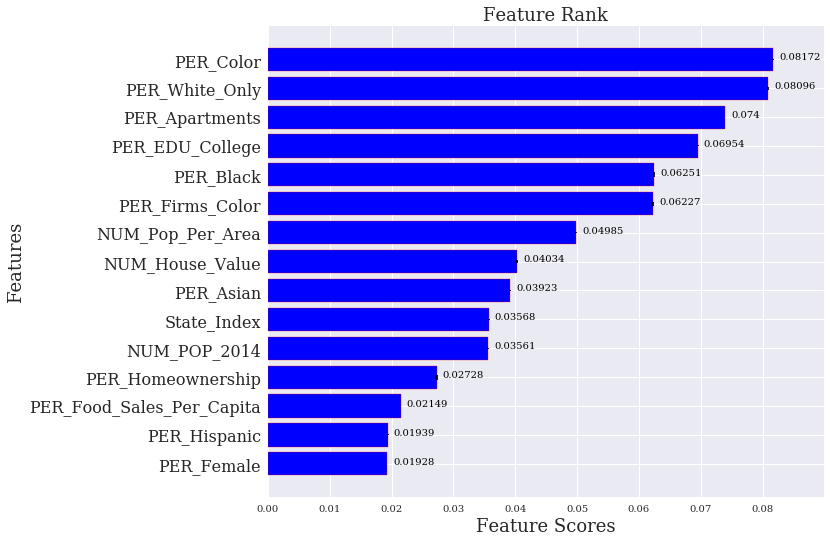

             precision    recall  f1-score   support

      Trump       0.96      0.99      0.97       266
    Clinton       0.93      0.78      0.84        49

avg / total       0.95      0.96      0.95       315



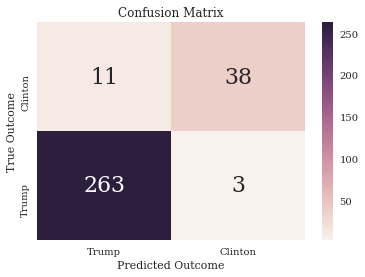


________________________FOLD 1________________________


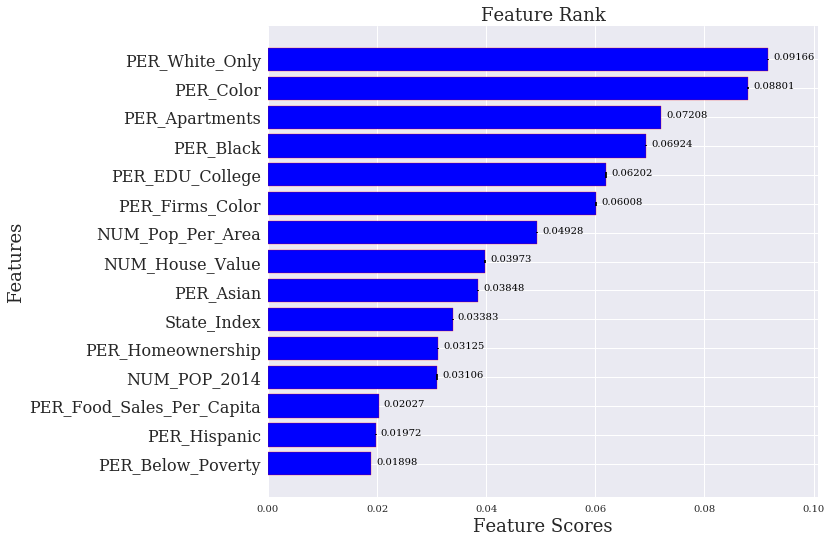

             precision    recall  f1-score   support

      Trump       0.94      0.99      0.97       266
    Clinton       0.92      0.67      0.78        49

avg / total       0.94      0.94      0.94       315



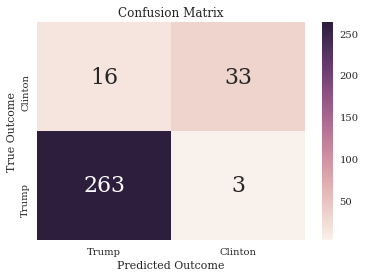


________________________FOLD 2________________________


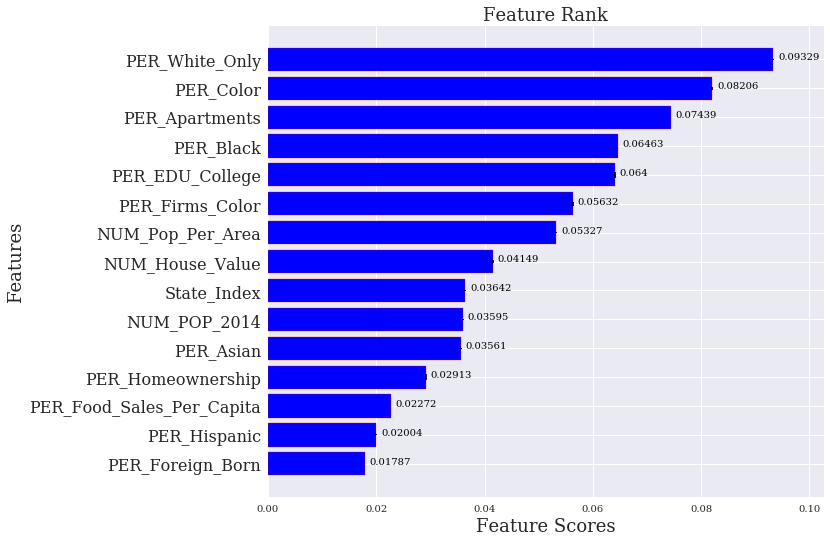

             precision    recall  f1-score   support

      Trump       0.96      0.97      0.96       266
    Clinton       0.82      0.76      0.79        49

avg / total       0.93      0.94      0.94       315



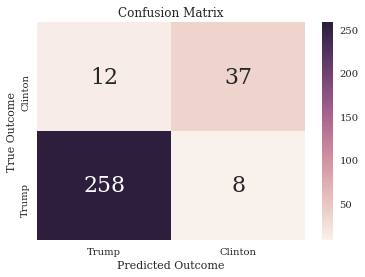


________________________FOLD 3________________________


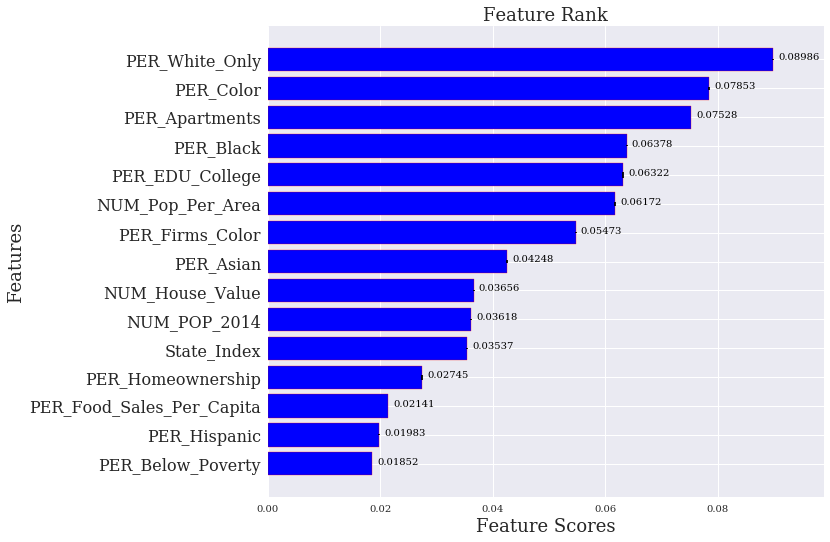

             precision    recall  f1-score   support

      Trump       0.95      0.98      0.96       266
    Clinton       0.86      0.73      0.79        49

avg / total       0.94      0.94      0.94       315



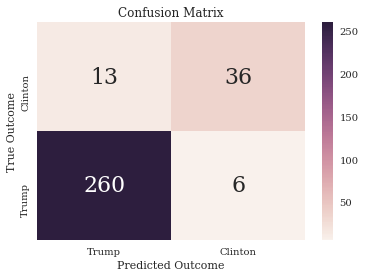


________________________FOLD 4________________________


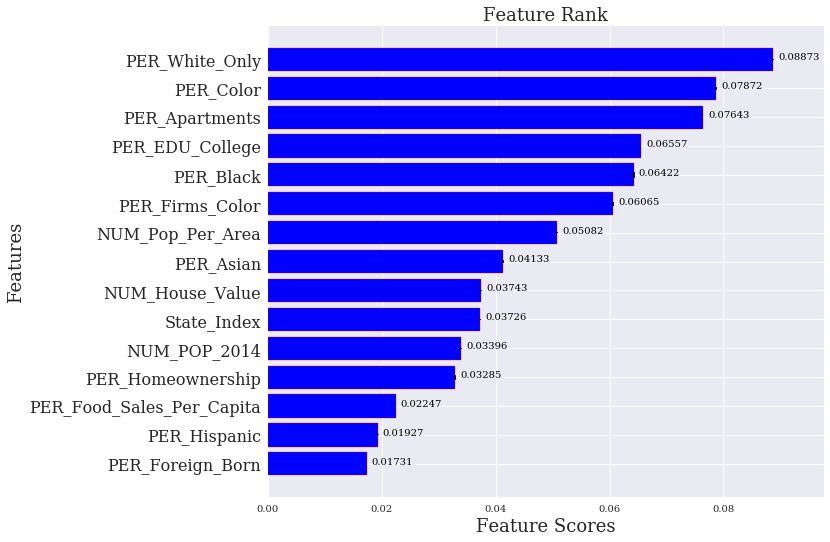

             precision    recall  f1-score   support

      Trump       0.97      0.98      0.98       265
    Clinton       0.91      0.84      0.87        49

avg / total       0.96      0.96      0.96       314



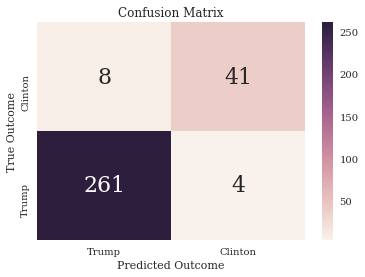


________________________FOLD 5________________________


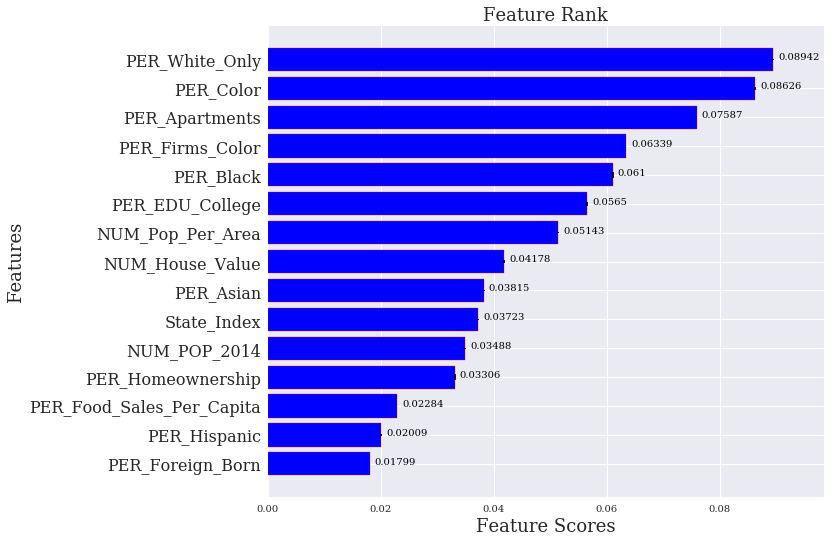

             precision    recall  f1-score   support

      Trump       0.97      0.97      0.97       265
    Clinton       0.85      0.82      0.83        49

avg / total       0.95      0.95      0.95       314



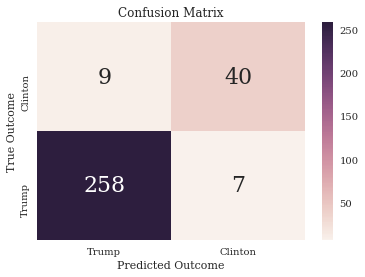


________________________FOLD 6________________________


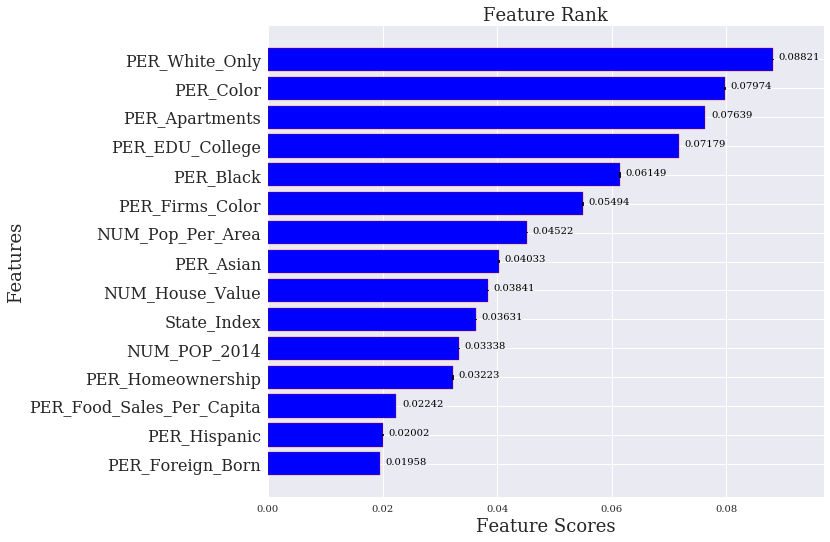

             precision    recall  f1-score   support

      Trump       0.97      0.98      0.97       265
    Clinton       0.87      0.82      0.84        49

avg / total       0.95      0.95      0.95       314



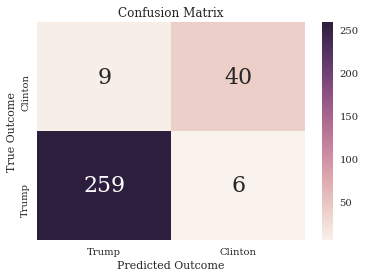


________________________FOLD 7________________________


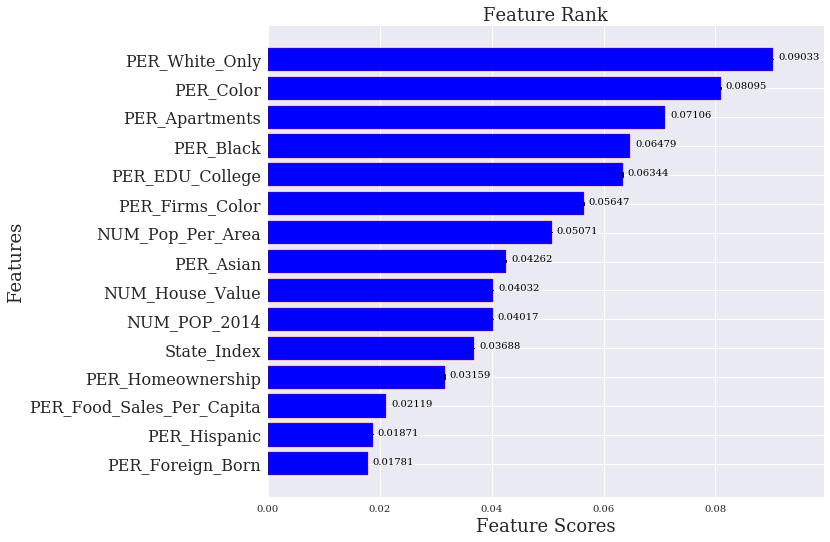

             precision    recall  f1-score   support

      Trump       0.95      0.98      0.96       265
    Clinton       0.85      0.69      0.76        48

avg / total       0.93      0.93      0.93       313



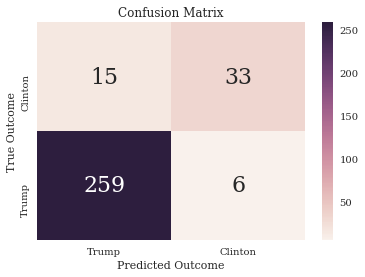


________________________FOLD 8________________________


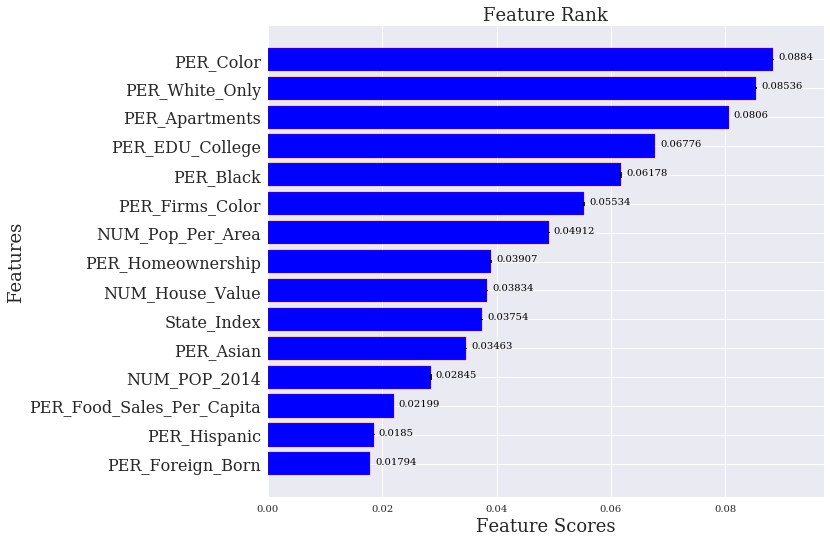

             precision    recall  f1-score   support

      Trump       0.96      0.98      0.97       265
    Clinton       0.88      0.79      0.84        48

avg / total       0.95      0.95      0.95       313



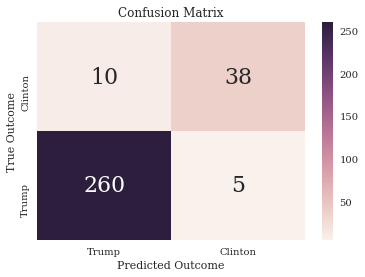


________________________FOLD 9________________________


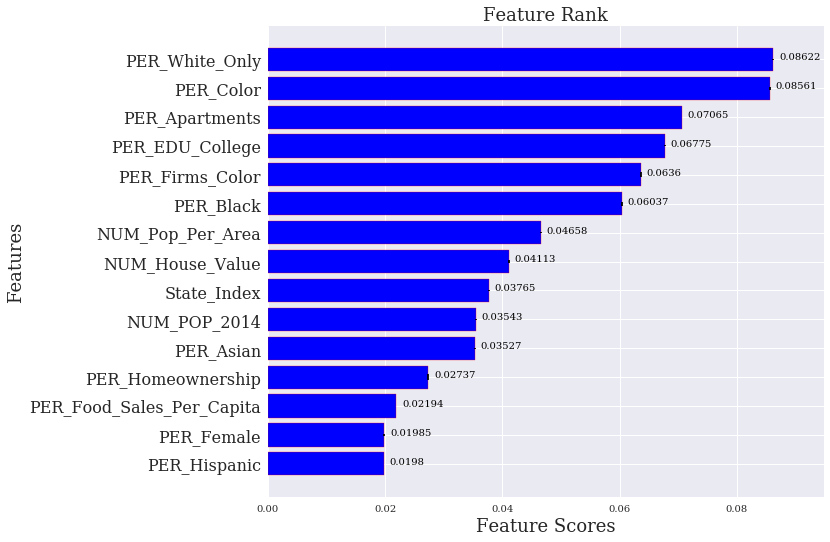

             precision    recall  f1-score   support

      Trump       0.96      0.98      0.97       265
    Clinton       0.88      0.79      0.84        48

avg / total       0.95      0.95      0.95       313



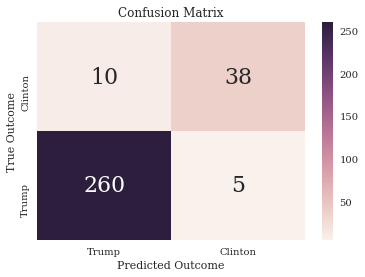



________________________OVERALL________________________
             precision    recall  f1-score   support

      Trump       0.96      0.98      0.97      2654
    Clinton       0.88      0.77      0.82       487

avg / total       0.95      0.95      0.95      3141



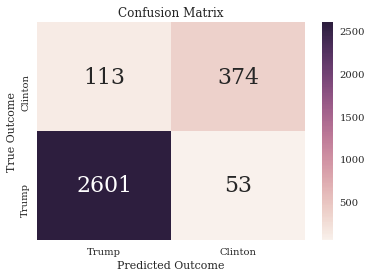

In [161]:
y_true, y_pred = cross_validation_rfc(rdf[features], rdf[classify_var[1]], ['Trump', 'Clinton'],
                                      plot=True, verbose=False, kfolds=10)

---
# $\S$8. <font color='blue'> Feedforward Neural Network</font>

## 8.1. <font color='green'> Generating a Generic Feedforward Neural Network </font>
We create a method to generate feedforward neural networks using Keras. This method allows us to control a neural network's depth and width while adding the option to apply early stopping and dropout regularization.

In [127]:
def feedforward_nn(nodes_per_layer,
                   hidden_activation='relu', output_activation='relu',
                   loss='mse', optimizer='Adam', batch_norm=True,
                   dropout_rate=None, best_params=True, earlystop=None, tb=False):
    
    """ 
    Creates a neural network with the width & depth of the network specified by 'nodes_per_layer'.
        
    :params (1) nodes_per_layer: (List) Sequentially lists number of nodes in each layer,
                                 including the size of input and and output layers.
            (2) hidden_activation: Specifies the type of activation function to use
                                   for every hidden layer.
            (3) output_activation: Specifies the type of activation function to use
                                   at the output layer.
            (4) loss: Specifies the type of loss function to compute the cost.
            (5) optimizer: Specifies the type of optimization method for gradient descent.
            (6) dropout_rate: (Float) Specifies the dropout rate for every hidden
                              layer. If dropout_rate=None, dropout regularization is
                              not applied to the network.
            (7) earlystop: (Dictionary) Specifies the 'min_delta' (the minimum change
                           in the validation loss) and the 'patience' (the number of
                           epochs to wait with no improvement before terminating).
                           If early_stop=None, early stopping is not applied.
            (8) tb: (Boolean) If tb=True, keras writes out TensorBoard logs for
                    debugging with TensorBoard. If tb=False, logs are not created.
    
    : returns (1) Neural Network Model (and Dictionary of Callbacks if Early
                  Stopping is applied or tb is set to write out.)
    """
    
    # Defines the Input Layer by Constructing a Tensor
    input      = Input(shape=(nodes_per_layer[0],))
    output     = input
    
    # If dropout_rate is specified, dropout is applied to the input layer.
    # Do NOT use if Batch Normalization is Used!!
    if dropout_rate is not None:
        output = Dropout(dropout_rate)(output)
    
    # Counters for While Loop Iteration
    nth_layer  = 1                         # Layer Counter
    num_layers = len(nodes_per_layer) - 1  # Target: Total # of Layers in NN

    # Defines Nth Hidden Layer
    while nth_layer < num_layers:
        output = Dense(nodes_per_layer[nth_layer],
                       input_dim=nodes_per_layer[nth_layer-1],
                       activation=hidden_activation)(output)

        # If dropout_rate is specified, dropout is applied to every hidden layer
        if dropout_rate is not None:
            output = Dropout(dropout_rate)(output)

        nth_layer+=1

    # Applies Batch Normalization if batch_norm is set True.
    # Do NOT Use if Dropout is Used!!
    if batch_norm:
        output = BatchNormalization()(output)
        
    # Defines Output Layer
    output = Dense(nodes_per_layer[nth_layer],
                   activation=output_activation)(output)
    
    # Creates the Neural Network Model
    nn = Model(inputs=input, outputs=output)
    
    # Compiles the NN model:
    # Converts the series of layers to efficient matrix computations
    nn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    # Tracks all Callbacks
    callbacks = []

    # Writes a Callback Log for Best Model Parameters
    if best_params:
        checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)
        callbacks.append(checkpointer)

    
    # Writes a Callback Log for EarlyStopping
    if earlystop:
        
        # Early Stopping is implemented by storing model parameters in a callback
        early_stopping = EarlyStopping(monitor='val_loss',
                                       verbose=1,
                                       mode='auto',
                                       **earlystop)
                                       
        callbacks.append(early_stopping)

    # Writes a Callback Log for TensorBoard to visualize dynamical graphs of the
    # Training and Test Metrics + Activation Histograms of the Different Layers
    # See More: https://keras.io/callbacks/#tensorboard
    if tb:
        
        # TensorBoard Logs will be timestamped to prevent overwriting.
        tensorboard = TensorBoard(log_dir="./logs/hidden-{}".format(
                                      time.strftime("%Y%m%d-%H%M%S")),
                                  histogram_freq=1,
                                  write_graph=False,
                                  write_grads=True)
        callbacks.append(tensorboard)

    # Returns both the NN Model and the Callbacks if Any Callbacks are Present
    if callbacks:
        return nn, {'callbacks': callbacks}

    return nn


## 8.2. <font color='green'>Building an Election Classifier</font>

In [128]:
def election_nn_classifier(n_inputs: int, n_outputs: int):

    """
    Creates the specific feedforward neural network architecture necessary to predict
    the party winner of the 2016 presidential election.
    
    Returns the model & the optimal parameters.
    """
    
    # Model Parameters (Adjust for Hyper-Parameter Tuning)
    batch_norm   = True                   # Batch Normalization
    dropout_rate = 0.0                    # Dropout Rate
    hidden_nodes = [25, 20, 10, 5]        # List of #Units Per Hidden Layer
    loss         = 'binary_crossentropy'  # Loss Function
    opt          = 'Adam'                 # Optimizer
    output_act   = 'tanh'                 # Output Activation Function
    min_delta    = 0.1                    # Minimum Change in Validation Loss
    patience     = 5                      # #Epochs to Wait Before Terminating
    
    
    # Number of Nodes in Each Layer of the Network
    npl = [n_inputs] + hidden_nodes + [n_outputs]
    
    # NEURAL NETWORK WITH EARLY STOPPING
    nn, params = feedforward_nn(nodes_per_layer=npl,
                                batch_norm=batch_norm,
                                dropout_rate=dropout_rate,
                                loss=loss,
                                optimizer=opt,
                                output_activation=output_act,
                                earlystop={'min_delta':min_delta, 'patience':patience})
    
    return nn, params

## 8.3 <font color='green'>Training & Testing the Neural Network </font>

In [165]:
def predict_election(X, y, classes,
                     batch_size=16, epochs=10,
                     kfolds=5, shuffle=True, random_state=100, verbose=False,
                     plot=True, file="nn_cv.pdf"):
    
    """
    Trains and tests neural network performance via k-fold cross-validation.
    """

    # Defines the Type of Cross-Validation
    skf = KFold(n_splits=kfolds, shuffle=shuffle, random_state=random_state)
    
    # Stores Model Selection & Model Performance Results
    y_true = pd.DataFrame()
    y_pred = pd.DataFrame()
    y_prob = pd.DataFrame()

    # Splits the Dataset into the Training & Validation/Test Sets
    # Cross Validation: Iterates through Each Fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X=X, y=y)):
    
        print("\n________________________FOLD {0}_______________________\n".format(fold))
    
        train_X = pd.DataFrame(X, index=train_idx)
        train_Y = pd.DataFrame(y, index=train_idx) #.values.ravel()
        test_X  = pd.DataFrame(X, index=test_idx)
        test_Y  = pd.DataFrame(y, index=test_idx) #.values.ravel()
        

        # Feedforward Neural Netword Model
        model, params = election_nn_classifier(n_inputs=X.shape[1], n_outputs=1)

        # Fit Model
        history = model.fit(train_X, train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            validation_data=(test_X, test_Y),
                            shuffle=True,
                            **params)

        # Make Predictions
        prob = model.predict(test_X)
        pred = np.array([1 if p>0 else -1 for p in prob]).reshape(prob.shape)
        
        # Computes Performance Metrics if Test Results are Available
        print(classification_report(test_Y, pred, target_names=classes))
        
        # Appends Fold Results into DataFrame Storing All Results
        y_true = y_true.append(pd.DataFrame(test_Y), ignore_index=True)
        y_pred = y_pred.append(pd.DataFrame(pred),   ignore_index=True)
        y_prob = y_prob.append(pd.DataFrame(prob),   ignore_index=True)
        
        # Plot Confusion Matrix for Each Fold
        if plot:
            plot_confusion_matrix(test_Y, pred, labels=classes, file="nn_cv{}.pdf".format(fold))
    
    
    # Computes Performance Metrics & Plots Confusion Matrix for Predictions Across All Folds    
    print("\n\n________________________OVERALL________________________\n")    
    print(classification_report(y_true, y_pred, target_names=classes))
    plot_confusion_matrix(y_true, y_pred, labels=classes, file="nn_cv.pdf")
    
    
    return y_prob, y_pred, y_true

## 8.4 <font color='green'>Prediction Results & Performance Metrics</font>


________________________FOLD 0_______________________


Epoch 00001: val_loss improved from inf to -11.93401, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss did not improve from -11.93401

Epoch 00003: val_loss did not improve from -11.93401

Epoch 00004: val_loss did not improve from -11.93401

Epoch 00005: val_loss did not improve from -11.93401

Epoch 00006: val_loss did not improve from -11.93401
Epoch 00006: early stopping
             precision    recall  f1-score   support

      Trump       0.92      0.93      0.92       542
    Clinton       0.53      0.51      0.52        87

avg / total       0.87      0.87      0.87       629



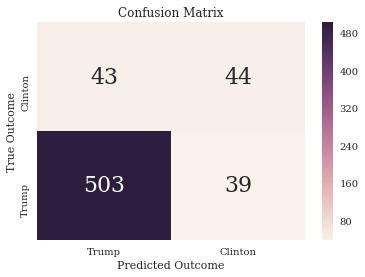


________________________FOLD 1_______________________


Epoch 00001: val_loss improved from inf to -6.11595, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss improved from -6.11595 to -11.40668, saving model to /tmp/weights.hdf5

Epoch 00003: val_loss did not improve from -11.40668

Epoch 00004: val_loss improved from -11.40668 to -11.77846, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss did not improve from -11.77846

Epoch 00006: val_loss improved from -11.77846 to -11.78160, saving model to /tmp/weights.hdf5

Epoch 00007: val_loss improved from -11.78160 to -11.83284, saving model to /tmp/weights.hdf5

Epoch 00008: val_loss did not improve from -11.83284

Epoch 00009: val_loss did not improve from -11.83284
Epoch 00009: early stopping
             precision    recall  f1-score   support

      Trump       0.88      0.99      0.93       542
    Clinton       0.61      0.13      0.21        86

avg / total       0.84      0.87      0.83       628



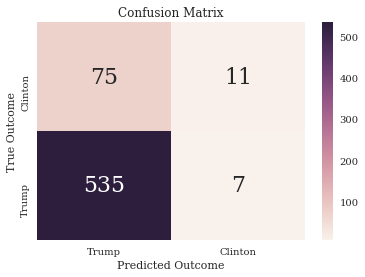


________________________FOLD 2_______________________


Epoch 00001: val_loss improved from inf to -11.04127, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss did not improve from -11.04127

Epoch 00003: val_loss did not improve from -11.04127

Epoch 00004: val_loss improved from -11.04127 to -11.06754, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss did not improve from -11.06754

Epoch 00006: val_loss improved from -11.06754 to -11.14407, saving model to /tmp/weights.hdf5

Epoch 00007: val_loss did not improve from -11.14407

Epoch 00008: val_loss did not improve from -11.14407

Epoch 00009: val_loss did not improve from -11.14407

Epoch 00010: val_loss did not improve from -11.14407
             precision    recall  f1-score   support

      Trump       0.86      1.00      0.92       524
    Clinton       0.89      0.16      0.28       104

avg / total       0.86      0.86      0.81       628



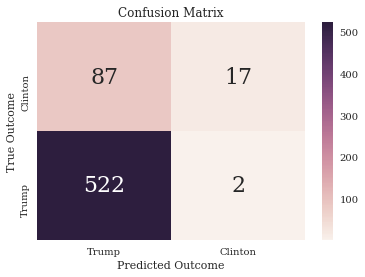


________________________FOLD 3_______________________


Epoch 00001: val_loss improved from inf to -11.36701, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss improved from -11.36701 to -11.53884, saving model to /tmp/weights.hdf5

Epoch 00003: val_loss improved from -11.53884 to -11.67253, saving model to /tmp/weights.hdf5

Epoch 00004: val_loss improved from -11.67253 to -11.81365, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss did not improve from -11.81365

Epoch 00006: val_loss did not improve from -11.81365

Epoch 00007: val_loss did not improve from -11.81365

Epoch 00008: val_loss did not improve from -11.81365

Epoch 00009: val_loss did not improve from -11.81365
Epoch 00009: early stopping
             precision    recall  f1-score   support

      Trump       0.91      0.95      0.93       531
    Clinton       0.64      0.51      0.56        97

avg / total       0.87      0.88      0.87       628



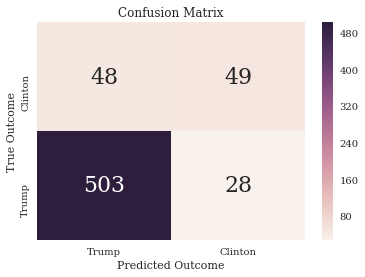


________________________FOLD 4_______________________


Epoch 00001: val_loss improved from inf to -8.90840, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss improved from -8.90840 to -10.35381, saving model to /tmp/weights.hdf5

Epoch 00003: val_loss improved from -10.35381 to -10.61031, saving model to /tmp/weights.hdf5

Epoch 00004: val_loss improved from -10.61031 to -10.63475, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss improved from -10.63475 to -10.70590, saving model to /tmp/weights.hdf5

Epoch 00006: val_loss did not improve from -10.70590

Epoch 00007: val_loss did not improve from -10.70590

Epoch 00008: val_loss improved from -10.70590 to -10.75591, saving model to /tmp/weights.hdf5

Epoch 00009: val_loss improved from -10.75591 to -10.79347, saving model to /tmp/weights.hdf5

Epoch 00010: val_loss did not improve from -10.79347
             precision    recall  f1-score   support

      Trump       0.83      0.88      0.85       515
    Clinton       

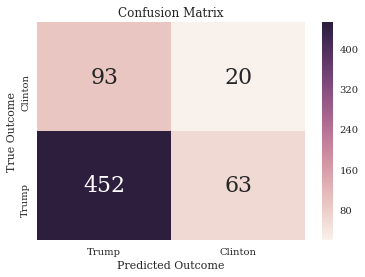



________________________OVERALL________________________

             precision    recall  f1-score   support

      Trump       0.88      0.95      0.91      2654
    Clinton       0.50      0.29      0.37       487

avg / total       0.82      0.85      0.83      3141



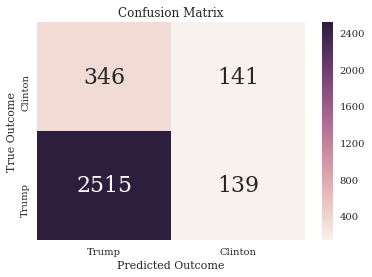

In [166]:
prob, pred, true = predict_election(X=rdf[features], y=rdf[classify_var[1]], classes=['Trump', 'Clinton'])